USAR XTREMEBOOST (KMEANS, DBSCAN, OUTROS) PARA AGRUPAR OS REGISTROS
COM AS TABELAS NO BIGQUERY, CONSUMIR AS COISAS DE LÁ
ALEM DO XTREMBOOST LOCAL, RODAR O ML_KMEANS DO SPARK E O ML_KMEANS DO BIGQUERY

no README
- explicar q sao 2 notebooks
- o primeiro notebook utilizou as bases fisicas, sem se conectar na internet
- o segundo notebook foi utilizado para realizar as analises e criar os graficos, machine learning para o app streamlit
- as bases de dados não serão disponibilizadas em conjunto com o notebook, mas há um link para download delas no app streamlit

# 1) Instalando dependências externas

In [ ]:
!pip install pyspark
!pip install google-cloud-bigquery
!pip install pywaffle

In [ ]:
from google.colab import auth
from google.colab import data_table
from google.cloud import bigquery
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pandas as pd
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from pywaffle import Waffle

# 2) Google Big Query

In [ ]:
# estabelece a conexão com GCP Big Query
project = 'silver-axon-412605'
schema = 'postech_fiap_data_science_danilo'
location = 'US'
client = bigquery.Client(project = project, location = location)
data_table.enable_dataframe_formatter()

auth.authenticate_user()

In [ ]:
# consulta todos os registros das tabelas de processados e auxiliares no Big Query e cria seus respectivos dataframes do pandas
query_job = client.query(f'''
  SELECT *
  FROM {schema}.pnad_covid_2020_processado
''')
df_pnad = query_job.result().to_dataframe()

In [ ]:
query_job = client.query(f'''
  SELECT *
  FROM {schema}.pnad_covid_2020_aux_capital
''')
df_capital = query_job.result().to_dataframe()

In [ ]:
query_job = client.query(f'''
  SELECT *
  FROM {schema}.pnad_covid_2020_aux_escolaridade
''')
df_escolaridade = query_job.result().to_dataframe()

In [ ]:
query_job = client.query(f'''
  SELECT *
  FROM {schema}.pnad_covid_2020_aux_medida_restricao
''')
df_medida_restricao = query_job.result().to_dataframe()

In [ ]:
query_job = client.query(f'''
  SELECT *
  FROM {schema}.pnad_covid_2020_aux_raca
''')
df_raca = query_job.result().to_dataframe()

In [ ]:
query_job = client.query(f'''
  SELECT *
  FROM {schema}.pnad_covid_2020_aux_regiao_metropolitana
''')
df_regiao_metropolitana = query_job.result().to_dataframe()

In [ ]:
query_job = client.query(f'''
  SELECT *
  FROM {schema}.pnad_covid_2020_aux_resultado
''')
df_resultado_exame = query_job.result().to_dataframe()

In [ ]:
query_job = client.query(f'''
  SELECT *
  FROM {schema}.pnad_covid_2020_aux_resposta
''')
df_resposta = query_job.result().to_dataframe()

In [ ]:
query_job = client.query(f'''
  SELECT *
  FROM {schema}.pnad_covid_2020_aux_sexo
''')
df_sexo = query_job.result().to_dataframe()

In [ ]:
query_job = client.query(f'''
  SELECT *
  FROM {schema}.pnad_covid_2020_aux_situacao_domicilio
''')
df_situacao_domicilio = query_job.result().to_dataframe()

In [ ]:
query_job = client.query(f'''
  SELECT *
  FROM {schema}.pnad_covid_2020_aux_tipo_area
''')
df_tipo_area = query_job.result().to_dataframe()

In [ ]:
query_job = client.query(f'''
  SELECT *
  FROM {schema}.pnad_covid_2020_aux_uf
''')
df_uf = query_job.result().to_dataframe()

In [ ]:
df_pnad.shape

(1149197, 31)

In [ ]:
df_pnad.head()

,uf,capital,regiao_metropolitana,semana_mes_v1012,mes_v1013,situacao_domicilio_v1022,tipo_area_v1023,morador_idade_a002,morador_sexo_a003,morador_raca_a004,...,sintoma_perda_olfato_b00111,sintoma_dor_muscular_b00112,sintoma_diarreia_b00113,compareceu_estabelecimento_saude_b002,sedado_entubado_b006,tem_plano_saude_b007,resultado_exame_b009b,medida_restricao_contato_b011,trabalhou_remoto_c013,recebeu_auxilio_emergencial_d0051
0,11,11,<NA>,4,11,1,1,9,2,4,...,2,2,2,<NA>,<NA>,2,<NA>,4,<NA>,1
1,11,11,<NA>,1,11,1,1,8,1,4,...,2,2,2,<NA>,<NA>,2,<NA>,4,<NA>,1
2,11,11,<NA>,3,11,1,1,11,2,1,...,2,2,2,<NA>,<NA>,2,<NA>,4,<NA>,2
3,11,11,<NA>,3,11,1,1,9,1,4,...,2,2,2,<NA>,<NA>,2,<NA>,4,<NA>,1
4,11,11,<NA>,1,11,1,1,4,1,1,...,2,2,2,<NA>,<NA>,2,<NA>,3,<NA>,1


In [ ]:
df_pnad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149197 entries, 0 to 1149196
Data columns (total 31 columns):
 #   Column                                 Non-Null Count    Dtype
---  ------                                 --------------    -----
 0   uf                                     1149197 non-null  Int64
 1   capital                                270626 non-null   Int64
 2   regiao_metropolitana                   363972 non-null   Int64
 3   semana_mes_v1012                       1149197 non-null  Int64
 4   mes_v1013                              1149197 non-null  Int64
 5   situacao_domicilio_v1022               1149197 non-null  Int64
 6   tipo_area_v1023                        1149197 non-null  Int64
 7   morador_idade_a002                     1149197 non-null  Int64
 8   morador_sexo_a003                      1149197 non-null  Int64
 9   morador_raca_a004                      1149197 non-null  Int64
 10  morador_escolaridade_a005              1149197 non-null  Int64
 11

In [ ]:
# cria um schema do Spark para conversão do dataframe do pandas num dataframe do Spark
schema = StructType([StructField(x, IntegerType(), True) for x in df_pnad.columns])

In [ ]:
# cria a sessão no Spark
spark = SparkSession.builder.master("local[*]").getOrCreate()
# converte o dataframe do pandas com o schema previamente criado num dataframe do Spark
df_pnad_spark = spark.createDataFrame(df_pnad, schema=schema, verifySchema=False)
# cria uma view da PNAD dentro do contexto do Spark
df_pnad_spark.createOrReplaceTempView('pnad')

In [ ]:
# verificando a quantidade de registros no dataframe Spark
print(df_pnad_spark.count())

1149197


In [ ]:
# verificando a quantidade de registros na view (deve bater com as outras contagens)
spark.sql('''
  SELECT COUNT(1) as total
  FROM pnad
''').show()

+-------+
|  total|
+-------+
|1149197|
+-------+



In [ ]:
df_pnad_spark.printSchema()

root
 |-- uf: integer (nullable = true)
 |-- capital: integer (nullable = true)
 |-- regiao_metropolitana: integer (nullable = true)
 |-- semana_mes_v1012: integer (nullable = true)
 |-- mes_v1013: integer (nullable = true)
 |-- situacao_domicilio_v1022: integer (nullable = true)
 |-- tipo_area_v1023: integer (nullable = true)
 |-- morador_idade_a002: integer (nullable = true)
 |-- morador_sexo_a003: integer (nullable = true)
 |-- morador_raca_a004: integer (nullable = true)
 |-- morador_escolaridade_a005: integer (nullable = true)
 |-- sintoma_febre_b0011: integer (nullable = true)
 |-- sintoma_tosse_b0012: integer (nullable = true)
 |-- sintoma_dor_garganta_b0013: integer (nullable = true)
 |-- sintoma_dificuldade_respiracao_b0014: integer (nullable = true)
 |-- sintoma_dor_cabeca_b0015: integer (nullable = true)
 |-- sintoma_dor_peito_b0016: integer (nullable = true)
 |-- sintoma_nausea_b0017: integer (nullable = true)
 |-- sintoma_nariz_entupido_b0018: integer (nullable = true)
 |-

In [ ]:
df_pnad_spark.show(5)

+---+-------+--------------------+----------------+---------+------------------------+---------------+------------------+-----------------+-----------------+-------------------------+-------------------+-------------------+--------------------------+------------------------------------+------------------------+-----------------------+--------------------+----------------------------+--------------------+------------------------+---------------------------+---------------------------+-----------------------+-------------------------------------+--------------------+--------------------+---------------------+-----------------------------+---------------------+---------------------------------+
| uf|capital|regiao_metropolitana|semana_mes_v1012|mes_v1013|situacao_domicilio_v1022|tipo_area_v1023|morador_idade_a002|morador_sexo_a003|morador_raca_a004|morador_escolaridade_a005|sintoma_febre_b0011|sintoma_tosse_b0012|sintoma_dor_garganta_b0013|sintoma_dificuldade_respiracao_b0014|sintoma_dor_

# 3) Segmentando o público

## 3.1) Sexo

In [ ]:
df_pnad_sexo = df_pnad['morador_sexo_a003'].value_counts()

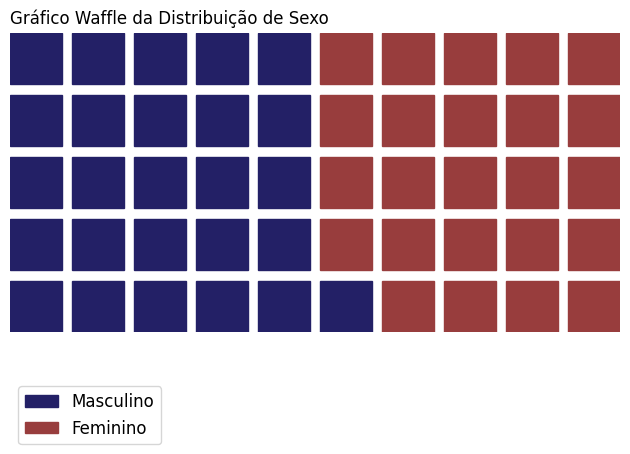

In [ ]:
fig = go.Figure()
fig.add_trace(go.Pie(labels=df_pnad_sexo.index, values=df_pnad_sexo.values, hole=.65))
fig.update_layout(title='Segmentação por sexo')
fig.show()

fig = plt.figure(
    FigureClass=Waffle,
    rows=5,
    columns=10,
    values=df_pnad_sexo,
    colors=["#232066", "#983D3D"],
    title={'label': 'Gráfico Waffle da Distribuição de Sexo', 'loc': 'left'},
    labels=["Masculino", "Feminino"],
    legend={'loc': 'lower left', 'bbox_to_anchor': (0, -0.4), 'fontsize': 12},
    plot_anchor='C'
)
plt.show()

## 3.2) Estado

In [ ]:
df_pnad_uf = df_pnad['uf'].value_counts()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Bar(x=df_pnad_uf.index, y=df_pnad_uf.values))
fig.update_layout(title='Segmentação por UF')
fig.show()

## 3.3) Região metropolitana

In [ ]:
df_pnad_regiao_metropolitana = df_pnad['regiao_metropolitana'].value_counts()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Bar(x=df_pnad_regiao_metropolitana.index, y=df_pnad_regiao_metropolitana.values))
fig.update_layout(title='Segmentação por RM')
fig.show()

## 3.4) Escolaridade

In [ ]:
df_pnad_escolaridade = df_pnad['morador_escolaridade_a005'].value_counts()

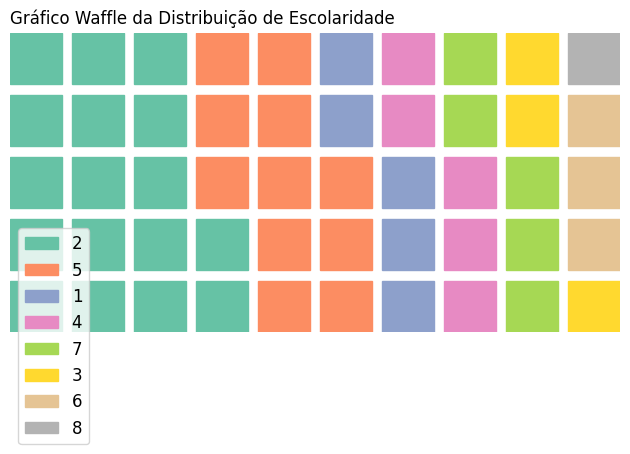

In [ ]:
fig = go.Figure()
fig.add_trace(go.Pie(labels=df_pnad_escolaridade.index, values=df_pnad_escolaridade.values, hole=.65))
fig.update_layout(title='Segmentação por escolaridade')
fig.show()

fig = plt.figure(
    FigureClass=Waffle,
    rows=5,
    columns=10,
    values=df_pnad_escolaridade,
    # colors=["#232066", "#983D3D"],
    title={'label': 'Gráfico Waffle da Distribuição de Escolaridade', 'loc': 'left'},
    labels=df_pnad_escolaridade.index.array,
    legend={'loc': 'lower left', 'bbox_to_anchor': (0, -0.4), 'fontsize': 12},
    plot_anchor='C'
)
plt.show()

## 3.5) Idade

In [ ]:
df_pnad_idade = df_pnad['morador_idade_a002'].value_counts(bins=[0, 18, 35, 50, 65, 80, 120], sort=False)

In [ ]:
faixas_etarias = df_pnad_idade.index.astype(str).tolist()
populacao = df_pnad_idade.values

# Criar o gráfico de barras horizontais
fig = go.Figure(go.Bar(
            x=populacao,
            y=faixas_etarias,
            orientation='h'))

# Atualizar o layout
fig.update_layout(title='Distribuição por Faixa Etária',
                  xaxis_title='Número de Indivíduos',
                  yaxis_title='Faixas Etárias')

# Mostrar o gráfico
fig.show()

## 3.6) Tem plano de sáude?

In [ ]:
df_pnad_plano_saude = df_pnad['tem_plano_saude_b007'].value_counts()

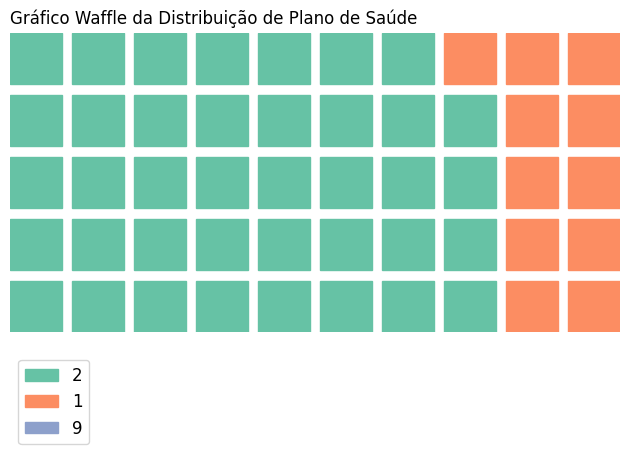

In [ ]:
fig = go.Figure()
fig.add_trace(go.Pie(labels=df_pnad_plano_saude.index, values=df_pnad_plano_saude.values, hole=.65))
fig.update_layout(title='Segmentação por sexo')
fig.show()

fig = plt.figure(
    FigureClass=Waffle,
    rows=5,
    columns=10,
    values=df_pnad_plano_saude,
    title={'label': 'Gráfico Waffle da Distribuição de Plano de Saúde', 'loc': 'left'},
    labels=df_pnad_plano_saude.index.array,
    legend={'loc': 'lower left', 'bbox_to_anchor': (0, -0.4), 'fontsize': 12},
    plot_anchor='C'
)
plt.show()

## 3.7) Sintomas mais comuns

In [39]:
df_pnad.columns

Index(['uf', 'capital', 'regiao_metropolitana', 'semana_mes_v1012',
       'mes_v1013', 'situacao_domicilio_v1022', 'tipo_area_v1023',
       'morador_idade_a002', 'morador_sexo_a003', 'morador_raca_a004',
       'morador_escolaridade_a005', 'sintoma_febre_b0011',
       'sintoma_tosse_b0012', 'sintoma_dor_garganta_b0013',
       'sintoma_dificuldade_respiracao_b0014', 'sintoma_dor_cabeca_b0015',
       'sintoma_dor_peito_b0016', 'sintoma_nausea_b0017',
       'sintoma_nariz_entupido_b0018', 'sintoma_fadiga_b0019',
       'sintoma_dor_olhos_b00110', 'sintoma_perda_olfato_b00111',
       'sintoma_dor_muscular_b00112', 'sintoma_diarreia_b00113',
       'compareceu_estabelecimento_saude_b002', 'sedado_entubado_b006',
       'tem_plano_saude_b007', 'resultado_exame_b009b',
       'medida_restricao_contato_b011', 'trabalhou_remoto_c013',
       'recebeu_auxilio_emergencial_d0051'],
      dtype='object')

In [44]:
df_resposta

,id,nome
0,9,Ignorado
1,2,Não
2,3,Não sabe
3,1,Sim


In [45]:
df_pnad_sintomas = df_pnad[['sintoma_febre_b0011',
       'sintoma_tosse_b0012', 'sintoma_dor_garganta_b0013',
       'sintoma_dificuldade_respiracao_b0014', 'sintoma_dor_cabeca_b0015',
       'sintoma_dor_peito_b0016', 'sintoma_nausea_b0017',
       'sintoma_nariz_entupido_b0018', 'sintoma_fadiga_b0019',
       'sintoma_dor_olhos_b00110', 'sintoma_perda_olfato_b00111',
       'sintoma_dor_muscular_b00112', 'sintoma_diarreia_b00113']]
df_pnad_sintomas = df_pnad_sintomas[(df_pnad_sintomas == 1).any(axis=1)] # pelo menos 1 sintoma

In [ ]:
# TODO: talvez mostrar um grafico de barras invertido???
# sintomas no Y, total no X

<Axes: >

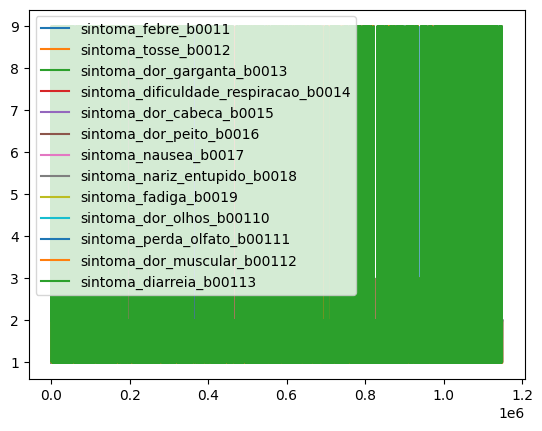

In [47]:
df_pnad_sintomas.plot()

## 3.8) Sintoma + resultado positivo

## 3.9) Escolaridade + resultado positivo

## 3.10) Tem plano de saúde + resultado positivo

In [ ]:


# tirar prints das tabelas atualizadas e alguns selects la do big query
# falar sobre o dataproc (como ele funciona por meio de upload dos scripts python ou atraves da disponibilizacao de um env jupyter), mas q nao sera utilizado

# 4) Machine Learning

In [ ]:
# TALVEZ RODAR VIA DATAPROC? (EXPLICAR NO TRABALHO SOBRE ELE)
#https://cloud.google.com/dataproc/docs/tutorials/bigquery-sparkml?hl=pt-br

# IDEIAS DE GRAFICOS PARA SUBSTITUIR O PIECHART
#https://plotly.com/python/treemaps/
#https://inforiver.com/insights/11-pie-chart-alternatives-and-when-to-use-them/